In [1]:
import os
import numpy as np
import soundfile as sf
import tensorflow as tf
import matplotlib.pyplot as plt
import source_separation.evaluation_metrics as ev_met
from ast import literal_eval
from tqdm import tqdm
from utils import signal_segmentation, find_segments_limits
from process_functions import preprocessing_audio
from heart_sound_segmentation.filter_and_sampling import downsampling_signal, upsampling_signal, \
    lowpass_filter, highpass_filter
from source_separation.nmf_decompositions import nmf_to_all, nmf_on_segments, \
    nmf_masked_segments
from IPython.display import Audio

In [2]:
def get_mixed_signal(signal_in_1, signal_in_2, snr_expected,
                     plot_signals=False, print_snr=False, normalize=True):
    '''Función que permite mezclar 2 señales en base a una especificación 
    SNR en decibeles.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    snr_expected : float
        Relación SNR deseada para la relación entre la señal 1 y la 
        señal 2.
    plot_signal : bool, optional
        Booleano para preguntar si es que se grafica la señal original en 
        conjunto con el ruido blanco generado. Por defecto es False.
    normalize : bool, optional
        Booleano para normalizar la señal de salida. Por defecto es True.
        
    Returns
    -------
    signal_out : ndarray
        Señales mezcladas según la relación "snr_expected" en dB.
    '''
    # Largo final de la señal será el largo de la señal más corta
    len_to = min(len(signal_in_1), len(signal_in_2))
    
    # Modificando la señal
    signal_in_1 = signal_in_1[:len_to]
    signal_in_2 = signal_in_2[:len_to]
    
    # Calcular la energía de las señales de entrada
    e_signal_1 = np.sum(signal_in_1 ** 2)
    e_signal_2 = np.sum(signal_in_2 ** 2)
    
    # Calculando el coeficiente necesario para que la energía del ruido
    # cumpla con la SNR especificada
    k = 10 ** (snr_expected / 10)
        
    # Se define pondera la primera señal. A partir de la relación
    # k = e1/e2, se espera que la energía de la señal sea e1 = k * e2.
    # Dado que la energía de la señal 1 es e1, entonces al dividir
    # la energía e1 de la señal por e1, y multiplicando por k * e2 
    # se obtiene la ponderación real. El sqrt(.) es del paso de 
    # energía a señal.
    signal_in_1 = np.sqrt(k * e_signal_2 / e_signal_1) * signal_in_1
    
    # Mostrar el SNR obtenido
    if print_snr:
        snr_obt = 10 * np.log10(np.sum(signal_in_1 ** 2) / \
                                np.sum(signal_in_2 ** 2))
        print(f'SNR obtained = {snr_obt} dB')
    
    # Finalmente se agrega la señal de entrada
    signal_out = signal_in_1 + signal_in_2
    
    # Normalizando
    if normalize:
        signal_out = signal_out / max(abs(signal_out))
        
    # Graficando
    if plot_signals:
        plt.figure()
        plt.subplot(2,1,1)
        plt.plot(signal_out)
        plt.ylabel('Señal de salida')
        
        plt.subplot(2,1,2)
        plt.plot(signal_in_1)
        plt.plot(signal_in_2)
        plt.ylabel('Señales individuales')
        plt.show()
        
    return signal_out, signal_in_1, signal_in_2


def conditioning_signal(signal_in, samplerate, samplerate_des, bandwidth=100):
    if samplerate > samplerate_des:
        new_rate, signal_out = \
            downsampling_signal(signal_in, samplerate, 
                                freq_pass=samplerate_des//2 - bandwidth, 
                                freq_stop=samplerate_des//2)
    
    elif samplerate < samplerate_des:
        signal_out = \
            upsampling_signal(signal_in, samplerate, samplerate_des)
        
    else:
        signal_out = signal_in
    
    return signal_out

In [3]:
# Parámetro general
samplerate_des = 11025

In [4]:
# Definición de la dirección de la base de datos
db_HR = '_beta_cardiorespiratory_database/Heart_Resp_Sounds'

# Parámetros de la función
lowpass_params = {'freq_pass': 140, 'freq_stop': 150}
model_name = 'definitive_segnet_based'

# Segmentación de los sonidos cardiacos puros

In [13]:
# Definición de la dirección de la base de datos
db_heart = '_beta_cardiorespiratory_database/Heart_Sounds'

# Archivos .wav de la carpeta
heart_filenames = [i for i in os.listdir(db_heart) if i.endswith('.wav')]

# Ejemplo
audio, samplerate = sf.read(f'{db_heart}/{heart_filenames[3]}')

In [14]:
%matplotlib notebook
_, y_hat_to, (y_out2, _, _) = \
        signal_segmentation(audio, samplerate, model_name,
                            length_desired=len(audio), 
                            lowpass_params=lowpass_params, 
                            plot_outputs=False)

Downsampling de la señal de fs = 44100 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step


<IPython.core.display.Javascript object>


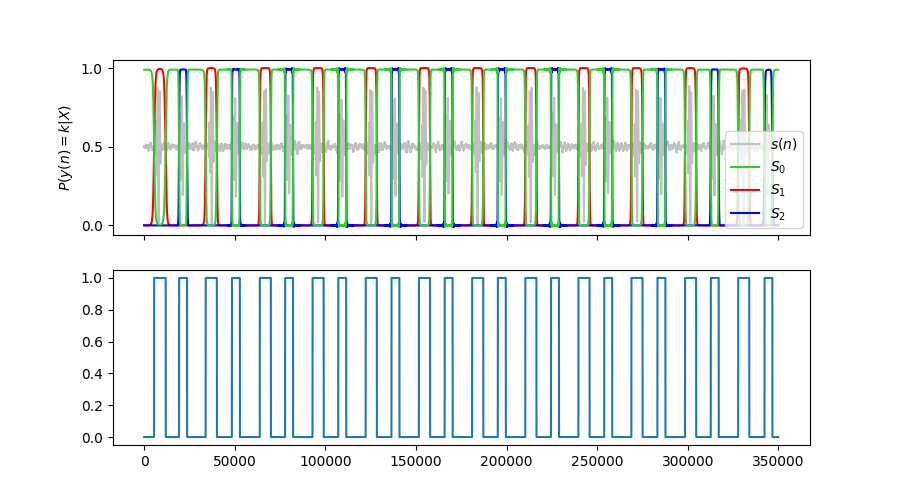

In [15]:
%matplotlib notebook
fig, ax = plt.subplots(2, 1, figsize=(9,5), sharex=True)
audio_data_plot = 0.5 * audio / max(abs(audio))
ax[0].plot(audio_data_plot - min(audio_data_plot), label=r'$s(n)$', 
         color='silver', zorder=0)
ax[0].plot(y_hat_to[0,:,0], label=r'$S_0$', color='limegreen', zorder=2)
ax[0].plot(y_hat_to[0,:,1], label=r'$S_1$', color='red', zorder=1)
ax[0].plot(y_hat_to[0,:,2], label=r'$S_2$', color='blue', zorder=1)
ax[0].legend(loc='lower right')
ax[0].set_yticks([0, 0.5, 1])
ax[0].set_ylabel(r'$P(y(n) = k | X)$')

ax[1].plot(y_out2)
plt.show()

# Separación de sonidos - Módulo de testeo

In [5]:
def nmf_process(signal_in, samplerate, hs_pos, interval_list, nmf_parameters,
                nmf_method='masked_segments'):
    '''
    
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal a descomponer.
    samplerate : int
        Tasa de muestreo de la señal.
    hs_pos : ndarray
        Señal binaria que indica las posiciones de los sonidos cardiacos.
    interval_list : list
        Lista con los intervalos donde se encuentran los sonidos cardiacos.
    nmf_parameters : dict
        Diccionario que contiene los parámetros de las funciones de 
        descomposición NMF.
    nmf_method : {'to_all', 'on_segments', 'masked_segments'}, optional
        Método de descomposición NMF a aplicar en la separación
        de fuentes. Por defecto es "masked_segments".
    
    Returns
    -------
    resp_signal : ndarray
        Señal respiratoria obtenida mediante la descomposición.
    heart_signal : ndarray
        Señal cardíaca obtenida mediante la descomposición.
    '''
    # Aplicando la separación de fuentes
    if nmf_method == 'to_all':
        (resp_signal, heart_signal), _ = \
            nmf_to_all(signal_in, samplerate, hs_pos=hs_pos, 
                       interval_list=interval_list, 
                       n_components=nmf_parameters['n_components'], 
                       N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'], 
                       noverlap=nmf_parameters['noverlap'], 
                       repeat=nmf_parameters['repeat'], 
                       padding=nmf_parameters['padding'], 
                       window=nmf_parameters['window'],
                       init=nmf_parameters['init'], 
                       solver=nmf_parameters['solver'], 
                       beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                       max_iter=nmf_parameters['max_iter'],
                       alpha_nmf=nmf_parameters['alpha_nmf'], 
                       l1_ratio=nmf_parameters['l1_ratio'], 
                       random_state=nmf_parameters['random_state'],
                       dec_criteria=nmf_parameters['dec_criteria'])
    
    
    elif nmf_method == 'on_segments':
        resp_signal, heart_signal = \
            nmf_on_segments(signal_in, samplerate, interval_list=interval_list, 
                            n_components=nmf_parameters['n_components'],
                            N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'],  
                            N_fade=nmf_parameters['N_fade'], 
                            noverlap=nmf_parameters['noverlap'], 
                            repeat=nmf_parameters['repeat'], 
                            padding=nmf_parameters['padding'], 
                            window=nmf_parameters['window'],
                            init=nmf_parameters['init'], 
                            solver=nmf_parameters['solver'], 
                            beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                            max_iter=nmf_parameters['max_iter'],
                            alpha_nmf=nmf_parameters['alpha_nmf'], 
                            l1_ratio=nmf_parameters['l1_ratio'], 
                            random_state=nmf_parameters['random_state'],
                            dec_criteria=nmf_parameters['dec_criteria'])
    
    
    elif nmf_method == 'masked_segments':
        (resp_signal, heart_signal), _ = \
            nmf_masked_segments(signal_in, samplerate, hs_pos=hs_pos, 
                                interval_list=interval_list, 
                                n_components=nmf_parameters['n_components'],
                                N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'],  
                                N_fade=nmf_parameters['N_fade'], 
                                noverlap=nmf_parameters['noverlap'], 
                                repeat=nmf_parameters['repeat'], 
                                padding=nmf_parameters['padding'], 
                                window=nmf_parameters['window'],
                                init=nmf_parameters['init'], 
                                solver=nmf_parameters['solver'], 
                                beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                                max_iter=nmf_parameters['max_iter'],
                                alpha_nmf=nmf_parameters['alpha_nmf'], 
                                l1_ratio=nmf_parameters['l1_ratio'], 
                                random_state=nmf_parameters['random_state'],
                                dec_criteria=nmf_parameters['dec_criteria'])
    
    return resp_signal, heart_signal

In [57]:
# Definición de la dirección de la base de datos de sonidos resp
db_resp = '_beta_cardiorespiratory_database/Resp_Sounds'
# Definición de la dirección de la base de datos de sonidos cardiacos
db_heart = '_beta_cardiorespiratory_database/Heart_Sounds'

# Archivos .wav de la carpeta
resp_filenames = [i for i in os.listdir(db_resp) if i.endswith('.wav')]
heart_filenames = [i for i in os.listdir(db_heart) if i.endswith('.wav')]


def preprocess_study(signal_index, nmf_parameters, snr_expected,
                     nmf_method='masked_segments',
                     plot_segmentation=False, 
                     plot_separation=False):
    ######### Import de archivos de audio #########
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
    
    # Realizando la mezcla
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Clasificando
    _, y_hat_to, (y_out2, _, _) = \
        signal_segmentation(heart_to, samplerate_des, model_name,
                            length_desired=len(mixed_to), 
                            lowpass_params=lowpass_params, 
                            plot_outputs=False)
    
    # Definiendo la lista de intervalos
    interval_list = find_segments_limits(y_out2, segments_return='Heart')
    
    if plot_segmentation:
        fig, ax = plt.subplots(2, 1, figsize=(9,5), sharex=True)
        mixed_to_plot = mixed_to / max(abs(mixed_to))
        audio_data_plot = 0.5 * mixed_to_plot / max(abs(mixed_to_plot))
        ax[0].plot(audio_data_plot - min(audio_data_plot), label=r'$s(n)$', 
                 color='silver', zorder=0)
        ax[0].plot(y_hat_to[0,:,0], label=r'$S_0$', color='limegreen', zorder=2)
        ax[0].plot(y_hat_to[0,:,1], label=r'$S_1$', color='red', zorder=1)
        ax[0].plot(y_hat_to[0,:,2], label=r'$S_2$', color='blue', zorder=1)
        ax[0].legend(loc='lower right')
        ax[0].set_yticks([0, 0.5, 1])
        ax[0].set_ylabel(r'$P(y(n) = k | X)$')

        ax[1].plot(y_out2)

        plt.show()
    
    

    ######### Separación de fuentes #########
    # Separando
    resp_pred, heart_pred = \
                nmf_process(mixed_to, samplerate_des, hs_pos=y_out2, 
                            interval_list=interval_list, 
                            nmf_parameters=nmf_parameters, 
                            nmf_method=nmf_method)
    
    if plot_separation:
        fig, ax = plt.subplots(3, 1, figsize=(15,7), sharex=True)

        ax[0].plot(mixed_to)
        ax[0].set_ylabel('Señal\noriginal')
        for i in interval_list:
            ax[0].axvspan(xmin=i[0], xmax=i[1], facecolor='purple', alpha=0.1)

        ax[1].plot(resp_to, color='C0', linewidth=2)
        ax[1].plot(resp_pred, color='C1')
        ax[1].set_ylabel('Señal\nRespiratoria')
        for i in interval_list:
            ax[1].axvspan(xmin=i[0], xmax=i[1], facecolor='purple', alpha=0.1)

        ax[2].plot(heart_to, color='C0', linewidth=2)
        ax[2].plot(heart_pred, color='C1')
        ax[2].set_ylabel('Señal\nCardiaca')
        for i in interval_list:
            ax[2].axvspan(xmin=i[0], xmax=i[1], facecolor='purple', alpha=0.1)

        # Ajustando las etiquetas del eje
        fig.align_ylabels(ax[:])
        # Quitando el espacio entre gráficos
        fig.subplots_adjust(wspace=0.1, hspace=0)

        plt.suptitle('Separación de fuentes')
        plt.show()
    
    
    
    ######### Análisis de la separación #########
    
    # Calculando las métricas
    temp_corr = ev_met.get_correlation(resp_to, resp_pred)
    spec_corr = ev_met.psd_correlation(resp_to, resp_pred, samplerate_des, 
                                       window='hann',
                                       N=nmf_parameters['N'], 
                                       noverlap=nmf_parameters['noverlap'])
    mse = ev_met.MSE(resp_to, resp_pred)
    sdr = ev_met.SDR(resp_to, resp_pred)
    
    print(f'Temp_correlation = {temp_corr}')
    print(f'Spec_correlation = {spec_corr}')
    print(f'MSE = {mse}')
    print(f'SDR = {sdr}')
    
    return ((resp_to, resp_pred), (heart_to, heart_pred), mixed_to,
            (temp_corr, spec_corr, mse, sdr))

SNR obtained = 9.64327466553287e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step


<IPython.core.display.Javascript object>


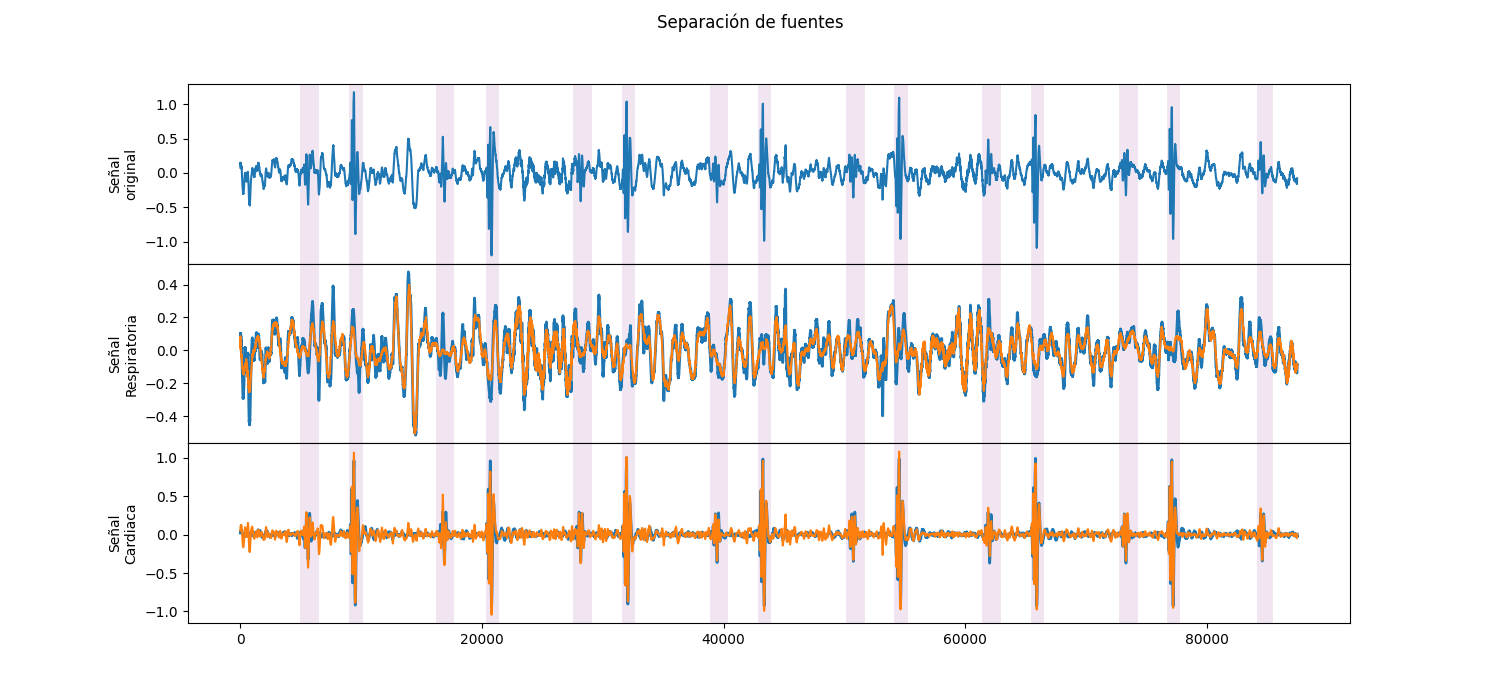

Temp_correlation = 0.9337471380157741
Spec_correlation = 0.979286404235794
MSE = 0.0022381897694794986
SDR = 8.447075138079645


In [58]:
nmf_parameters = {'n_components': 3, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 200, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'vote'}

signal_index = 10
%matplotlib notebook
a = preprocess_study(signal_index, nmf_parameters, snr_expected=0, 
                     nmf_method='to_all', plot_segmentation=False, 
                     plot_separation=True)

In [55]:
print(max(a))

1.0801993739062608


# Rutina de evaluación

In [6]:
# Definición de la dirección de la base de datos de sonidos resp
db_resp = '_beta_cardiorespiratory_database/Resp_Sounds'
# Definición de la dirección de la base de datos de sonidos cardiacos
db_heart = '_beta_cardiorespiratory_database/Heart_Sounds'

# Archivos .wav de la carpeta
resp_filenames = [i for i in os.listdir(db_resp) if i.endswith('.wav')]
heart_filenames = [i for i in os.listdir(db_heart) if i.endswith('.wav')]


def nmf_process(signal_in, samplerate, hs_pos, interval_list, nmf_parameters,
                nmf_method='masked_segments'):
    '''Proceso de descomposición NMF y evaluación en comparación con las 
    señales originales.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal a descomponer.
    samplerate : int
        Tasa de muestreo de la señal.
    hs_pos : ndarray
        Señal binaria que indica las posiciones de los sonidos cardiacos.
    interval_list : list
        Lista con los intervalos donde se encuentran los sonidos cardiacos.
    nmf_parameters : dict
        Diccionario que contiene los parámetros de las funciones de 
        descomposición NMF.
    nmf_method : {'to_all', 'on_segments', 'masked_segments'}, optional
        Método de descomposición NMF a aplicar en la separación
        de fuentes. Por defecto es "masked_segments".
    
    Returns
    -------
    resp_signal : ndarray
        Señal respiratoria obtenida mediante la descomposición.
    heart_signal : ndarray
        Señal cardíaca obtenida mediante la descomposición.
    '''
    # Aplicando la separación de fuentes
    if nmf_method == 'to_all':
        (resp_signal, heart_signal), _ = \
            nmf_to_all(signal_in, samplerate, hs_pos=hs_pos, 
                       interval_list=interval_list, 
                       n_components=nmf_parameters['n_components'], 
                       N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'], 
                       noverlap=nmf_parameters['noverlap'], 
                       repeat=nmf_parameters['repeat'], 
                       padding=nmf_parameters['padding'], 
                       window=nmf_parameters['window'],
                       init=nmf_parameters['init'], 
                       solver=nmf_parameters['solver'], 
                       beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                       max_iter=nmf_parameters['max_iter'],
                       alpha_nmf=nmf_parameters['alpha_nmf'], 
                       l1_ratio=nmf_parameters['l1_ratio'], 
                       random_state=nmf_parameters['random_state'],
                       dec_criteria=nmf_parameters['dec_criteria'])
    
    
    elif nmf_method == 'on_segments':
        resp_signal, heart_signal = \
            nmf_on_segments(signal_in, samplerate, interval_list=interval_list, 
                            n_components=nmf_parameters['n_components'],
                            N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'],  
                            N_fade=nmf_parameters['N_fade'], 
                            noverlap=nmf_parameters['noverlap'], 
                            repeat=nmf_parameters['repeat'], 
                            padding=nmf_parameters['padding'], 
                            window=nmf_parameters['window'],
                            init=nmf_parameters['init'], 
                            solver=nmf_parameters['solver'], 
                            beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                            max_iter=nmf_parameters['max_iter'],
                            alpha_nmf=nmf_parameters['alpha_nmf'], 
                            l1_ratio=nmf_parameters['l1_ratio'], 
                            random_state=nmf_parameters['random_state'],
                            dec_criteria=nmf_parameters['dec_criteria'])
    
    
    elif nmf_method == 'masked_segments':
        (resp_signal, heart_signal), _ = \
            nmf_masked_segments(signal_in, samplerate, hs_pos=hs_pos, 
                                interval_list=interval_list, 
                                n_components=nmf_parameters['n_components'],
                                N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'],  
                                N_fade=nmf_parameters['N_fade'], 
                                noverlap=nmf_parameters['noverlap'], 
                                repeat=nmf_parameters['repeat'], 
                                padding=nmf_parameters['padding'], 
                                window=nmf_parameters['window'],
                                init=nmf_parameters['init'], 
                                solver=nmf_parameters['solver'], 
                                beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                                max_iter=nmf_parameters['max_iter'],
                                alpha_nmf=nmf_parameters['alpha_nmf'], 
                                l1_ratio=nmf_parameters['l1_ratio'], 
                                random_state=nmf_parameters['random_state'],
                                dec_criteria=nmf_parameters['dec_criteria'])
    
    return resp_signal, heart_signal


def preprocess_study(signal_index, nmf_parameters, snr_expected,
                     nmf_method='masked_segments', print_metrics=False,
                     plot_segmentation=False, 
                     plot_separation=False):
    ######### Import de archivos de audio #########
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
    
    # Realizando la mezcla
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Clasificando
    _, y_hat_to, (y_out2, _, _) = \
        signal_segmentation(heart_to, samplerate_des, model_name,
                            length_desired=len(mixed_to), 
                            lowpass_params=lowpass_params, 
                            plot_outputs=False)
    
    # Definiendo la lista de intervalos
    interval_list = find_segments_limits(y_out2, segments_return='Heart')
    
    if plot_segmentation:
        fig, ax = plt.subplots(2, 1, figsize=(9,5), sharex=True)
        mixed_to_plot = mixed_to / max(abs(mixed_to))
        audio_data_plot = 0.5 * mixed_to_plot / max(abs(mixed_to_plot))
        ax[0].plot(audio_data_plot - min(audio_data_plot), label=r'$s(n)$', 
                 color='silver', zorder=0)
        ax[0].plot(y_hat_to[0,:,0], label=r'$S_0$', color='limegreen', zorder=2)
        ax[0].plot(y_hat_to[0,:,1], label=r'$S_1$', color='red', zorder=1)
        ax[0].plot(y_hat_to[0,:,2], label=r'$S_2$', color='blue', zorder=1)
        ax[0].legend(loc='lower right')
        ax[0].set_yticks([0, 0.5, 1])
        ax[0].set_ylabel(r'$P(y(n) = k | X)$')

        ax[1].plot(y_out2)

        plt.show()
    
    

    ######### Separación de fuentes #########
    # Separando
    resp_pred, heart_pred = \
                nmf_process(mixed_to, samplerate_des, hs_pos=y_out2, 
                            interval_list=interval_list, 
                            nmf_parameters=nmf_parameters, 
                            nmf_method=nmf_method)
    
    if plot_separation:
        fig, ax = plt.subplots(3, 1, figsize=(15,7), sharex=True)

        ax[0].plot(mixed_to)
        ax[0].set_ylabel('Señal\noriginal')
        for i in interval_list:
            ax[0].axvspan(xmin=i[0], xmax=i[1], facecolor='purple', alpha=0.1)

        ax[1].plot(resp_to, color='C0', linewidth=2)
        ax[1].plot(resp_pred, color='C1')
        ax[1].set_ylabel('Señal\nRespiratoria')
        for i in interval_list:
            ax[1].axvspan(xmin=i[0], xmax=i[1], facecolor='purple', alpha=0.1)

        ax[2].plot(heart_to, color='C0', linewidth=2)
        ax[2].plot(heart_pred, color='C1')
        ax[2].set_ylabel('Señal\nCardiaca')
        for i in interval_list:
            ax[2].axvspan(xmin=i[0], xmax=i[1], facecolor='purple', alpha=0.1)

        # Ajustando las etiquetas del eje
        fig.align_ylabels(ax[:])
        # Quitando el espacio entre gráficos
        fig.subplots_adjust(wspace=0.1, hspace=0)

        plt.suptitle('Separación de fuentes')
        plt.show()
    
    
    
    ######### Análisis de la separación #########
    
    # Calculando las métricas
    temp_corr = ev_met.get_correlation(resp_to, resp_pred)
    spec_corr = ev_met.psd_correlation(resp_to, resp_pred, samplerate_des, 
                                       window='hann',
                                       N=nmf_parameters['N'], 
                                       noverlap=nmf_parameters['noverlap'])
    mse = ev_met.MSE(resp_to, resp_pred)
    sdr = ev_met.SDR(resp_to, resp_pred)
    
    if print_metrics:
        print(f'Temp_correlation = {temp_corr}')
        print(f'Spec_correlation = {spec_corr}')
        print(f'MSE = {mse}')
        print(f'SDR = {sdr}')

    return ((resp_to, resp_pred), (heart_to, heart_pred), mixed_to,
            (temp_corr, spec_corr, mse, sdr))


def eval_db(nmf_method, snr_expected, nmf_parameters):
    #### Rutina ####
    
    # Definición de las listas que almacenarán los resultados
    temp_list = list()
    spec_list = list()
    mse_list = list()
    sdr_list = list()
    
    for signal_index in range(1, 13):
        # Aplicando 
        resp_signals, heart_signals, mixed_signal, metrics = \
            preprocess_study(signal_index, nmf_parameters, snr_expected,
                             nmf_method=nmf_method, plot_segmentation=False, 
                             plot_separation=False)
        
        # Agregando las métricas a cada lista
        temp_list.append(metrics[0])
        spec_list.append(metrics[1])
        mse_list.append(metrics[2])
        sdr_list.append(metrics[3])
    
    print()
    print(f'Results {nmf_method}')
    print('---------------------')
    print(f'Temporal correlation = {round(np.mean(temp_list), 4)} $\\pm$ {round(np.std(temp_list), 4)}')
    print(f'Spectral correlation = {round(np.mean(spec_list), 4)} $\\pm$ {round(np.std(spec_list), 4)}')
    print(f'MSE = {round(np.mean(mse_list), 4)} $\\pm$ {round(np.std(mse_list), 4)}')
    print(f'SDR = {round(np.mean(sdr_list), 4)} $\\pm$ {round(np.std(sdr_list), 4)}')

In [7]:
#### Parámetros ####
snr_expected = 0
nmf_parameters = {'n_components': 3, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 200, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'vote'}

In [8]:
nmf_method = 'to_all'
eval_db(nmf_method, snr_expected, nmf_parameters)

SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step
SNR obtained = 9.64327466553287e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step
SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step
SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step
SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step
SNR obtained = 9.64327466553287e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step
SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step
SNR obtained = -9.643274665532871e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1

In [9]:
nmf_method = 'on_segments'
eval_db(nmf_method, snr_expected, nmf_parameters)

SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segmentos
2 de 3 segmentos
1 de 3 segment

C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:826: RuntimeWarning: invalid value encountered in double_scalars
  if (previous_error - error) / error_at_init < tol:
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\Desktop\Scripts_Magister\Source_separation_main_v2\source_separation\math_functions.py:382: RuntimeWarning: invalid value encountered in true_divide
  r =  1 / (N - 1) * np.sum((A.T - mu_a).T * (b - mu_b), axis=1) / (sig_a * sig_b)
C:\Users\Chris\Desktop\Scripts_Magister\Source_separation_main_v2\source_separation\math_functions.py:385: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 1, 1, r)
C:\Users\Chris\Desktop\Scripts_Magister\Source_separation_main_v2\source_sepa

1 de 3 segmentos


ValueError: operands could not be broadcast together with shapes (100,) (0,) 

In [ ]:
nmf_method = 'masked_segments'
eval_db(nmf_method, snr_expected, nmf_parameters)

# Probar sobre una banda en específico

In [4]:
def nmf_process_v2(signal_in, samplerate, hs_pos, interval_list, nmf_parameters,
                filter_parameters, nmf_method='masked_segments'):
    '''Función que permite realizar la descomposición NMF en base a los 
    parámetros de interés a modificar.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal a descomponer.
    samplerate : int
        Tasa de muestreo de la señal.
    hs_pos : ndarray
        Señal binaria que indica las posiciones de los sonidos cardiacos.
    interval_list : list
        Lista con los intervalos donde se encuentran los sonidos cardiacos.
    nmf_parameters : dict
        Diccionario que contiene los parámetros de las funciones de 
        descomposición NMF.
    nmf_method : {'to_all', 'on_segments', 'masked_segments'}, optional
        Método de descomposición NMF a aplicar en la separación
        de fuentes. Por defecto es "masked_segments".
    
    Returns
    -------
    resp_signal : ndarray
        Señal respiratoria obtenida mediante la descomposición.
    heart_signal : ndarray
        Señal cardíaca obtenida mediante la descomposición.
    '''
    # Si es que se decide descomponer únicamente la franja de baja frecuencia 
    if filter_parameters['bool']:
        # Señal de entrada
        _, signal_to = \
                lowpass_filter(signal_in, samplerate,
                               freq_pass=filter_parameters['freq_pass'],
                               freq_stop=filter_parameters['freq_stop'],
                               normalize=False)
        
        # Señal a conectar con la respiración
        _, signal_upper = \
                highpass_filter(signal_in, samplerate, 
                                freq_stop=filter_parameters['freq_pass'], 
                                freq_pass=filter_parameters['freq_stop'],
                                normalize=False)
    
    else:
        signal_to = signal_in
    
    # Aplicando la separación de fuentes
    if nmf_method == 'to_all':
        (resp_signal, heart_signal), _ = \
            nmf_to_all(signal_to, samplerate, hs_pos=hs_pos, 
                       interval_list=interval_list, 
                       n_components=nmf_parameters['n_components'], 
                       N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'], 
                       noverlap=nmf_parameters['noverlap'], 
                       repeat=nmf_parameters['repeat'], 
                       padding=nmf_parameters['padding'], 
                       window=nmf_parameters['window'],
                       init=nmf_parameters['init'], 
                       solver=nmf_parameters['solver'], 
                       beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                       max_iter=nmf_parameters['max_iter'],
                       alpha_nmf=nmf_parameters['alpha_nmf'], 
                       l1_ratio=nmf_parameters['l1_ratio'], 
                       random_state=nmf_parameters['random_state'],
                       dec_criteria=nmf_parameters['dec_criteria'])
    
    
    elif nmf_method == 'on_segments':
        resp_signal, heart_signal = \
            nmf_on_segments(signal_to, samplerate, interval_list=interval_list, 
                            n_components=nmf_parameters['n_components'],
                            N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'],  
                            N_fade=nmf_parameters['N_fade'], 
                            noverlap=nmf_parameters['noverlap'], 
                            repeat=nmf_parameters['repeat'], 
                            padding=nmf_parameters['padding'], 
                            window=nmf_parameters['window'],
                            init=nmf_parameters['init'], 
                            solver=nmf_parameters['solver'], 
                            beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                            max_iter=nmf_parameters['max_iter'],
                            alpha_nmf=nmf_parameters['alpha_nmf'], 
                            l1_ratio=nmf_parameters['l1_ratio'], 
                            random_state=nmf_parameters['random_state'],
                            dec_criteria=nmf_parameters['dec_criteria'])
    
    
    elif nmf_method == 'masked_segments':
        (resp_signal, heart_signal), _ = \
            nmf_masked_segments(signal_to, samplerate, hs_pos=hs_pos, 
                                interval_list=interval_list, 
                                n_components=nmf_parameters['n_components'],
                                N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'],  
                                N_fade=nmf_parameters['N_fade'], 
                                noverlap=nmf_parameters['noverlap'], 
                                repeat=nmf_parameters['repeat'], 
                                padding=nmf_parameters['padding'], 
                                window=nmf_parameters['window'],
                                init=nmf_parameters['init'], 
                                solver=nmf_parameters['solver'], 
                                beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                                max_iter=nmf_parameters['max_iter'],
                                alpha_nmf=nmf_parameters['alpha_nmf'], 
                                l1_ratio=nmf_parameters['l1_ratio'], 
                                random_state=nmf_parameters['random_state'],
                                dec_criteria=nmf_parameters['dec_criteria'])
    
    
    # Si es que se filtró, se vuelve a conectar con la información de alta
    # frecuencia. 
    if filter_parameters['bool']: 
        # Filtrando frecuencias altas
        _, resp_signal = \
                lowpass_filter(resp_signal, samplerate,
                               freq_pass=filter_parameters['freq_pass'],
                               freq_stop=filter_parameters['freq_stop'], 
                               normalize=False)
        _, heart_signal = \
                lowpass_filter(heart_signal, samplerate,
                               freq_pass=filter_parameters['freq_pass'],
                               freq_stop=filter_parameters['freq_stop'], 
                               normalize=False)
        
        # Conectar la señal respiratoria con la banda superior de la señal
        resp_signal = resp_signal + signal_upper[:len(resp_signal)]
    
    return resp_signal, heart_signal


def preprocess_study(signal_index, nmf_parameters, snr_expected, filter_parameters,
                     nmf_method='masked_segments', print_metrics=False,
                     base_factor= 0.05, N_wind=100, plot_segmentation=False, 
                     plot_separation=False):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    ######### Import de archivos de audio #########
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Clasificando
    _, y_hat_to, (y_out2, _, _) = \
        signal_segmentation(heart_to, samplerate_des, model_name,
                            length_desired=len(mixed_to), 
                            lowpass_params=lowpass_params, 
                            plot_outputs=False)
    
    # Definiendo la lista de intervalos
    interval_list = find_segments_limits(y_out2, segments_return='Heart')
    
    if plot_segmentation:
        fig, ax = plt.subplots(2, 1, figsize=(9,5), sharex=True)
        mixed_to_plot = mixed_to / max(abs(mixed_to))
        audio_data_plot = 0.5 * mixed_to_plot / max(abs(mixed_to_plot))
        ax[0].plot(audio_data_plot - min(audio_data_plot), label=r'$s(n)$', 
                 color='silver', zorder=0)
        ax[0].plot(y_hat_to[0,:,0], label=r'$S_0$', color='limegreen', zorder=2)
        ax[0].plot(y_hat_to[0,:,1], label=r'$S_1$', color='red', zorder=1)
        ax[0].plot(y_hat_to[0,:,2], label=r'$S_2$', color='blue', zorder=1)
        ax[0].legend(loc='lower right')
        ax[0].set_yticks([0, 0.5, 1])
        ax[0].set_ylabel(r'$P(y(n) = k | X)$')

        ax[1].plot(y_out2)

        plt.show()
        
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    
    # Interactivo
#     fig, ax = plt.subplots(2,1, figsize=(7,7), sharex=True)
#     ax[0].plot(heart_to, label='Señal cardiaca')
#     ax[0].plot(conv_sign)
    
#     ax[1].plot(heart_to * conv_sign)
#     ax[1].set_xlim([0, 14000])
#     plt.show()
    
    # sf.write('_temp/heart.wav', heart_to / max(abs(heart_to)), samplerate_des)
    # sf.write('_temp/mixed_to.wav', mixed_to / max(abs(mixed_to)), samplerate_des)

    ######### Separación de fuentes #########
    # Separando
    resp_pred, heart_pred = \
                nmf_process_v2(mixed_to, samplerate_des, hs_pos=y_out2, 
                               interval_list=interval_list, 
                               nmf_parameters=nmf_parameters,
                               filter_parameters=filter_parameters,
                               nmf_method=nmf_method)
    
    if plot_separation:
        fig, ax = plt.subplots(3, 1, figsize=(15,7), sharex=True)

        ax[0].plot(mixed_to)
        ax[0].set_ylabel('Señal\noriginal')
        for i in interval_list:
            ax[0].axvspan(xmin=i[0], xmax=i[1], facecolor='purple', alpha=0.1)

        ax[1].plot(resp_to, color='C0', linewidth=2)
        ax[1].plot(resp_pred, color='C1')
        ax[1].set_ylabel('Señal\nRespiratoria')
        for i in interval_list:
            ax[1].axvspan(xmin=i[0], xmax=i[1], facecolor='purple', alpha=0.1)

        ax[2].plot(heart_to, color='C0', linewidth=2)
        ax[2].plot(heart_pred, color='C1')
        ax[2].set_ylabel('Señal\nCardiaca')
        for i in interval_list:
            ax[2].axvspan(xmin=i[0], xmax=i[1], facecolor='purple', alpha=0.1)

        # Ajustando las etiquetas del eje
        fig.align_ylabels(ax[:])
        # Quitando el espacio entre gráficos
        fig.subplots_adjust(wspace=0.1, hspace=0)

        plt.suptitle('Separación de fuentes')
        plt.show()
    
    # plt.figure(figsize=(15,7))
    # plt.subplot(2,1,1)
    # plt.plot(mixed_to, linewidth=3)
    # plt.plot(resp_pred + heart_pred)
    # for i in interval_list:
    #     plt.axvspan(xmin=i[0], xmax=i[1], facecolor='purple', alpha=0.1)
        
    # plt.subplot(2,1,2)
    # plt.plot(abs(mixed_to - (resp_pred + heart_pred)))
    # plt.show()
    
    ######### Análisis de la separación #########
    
    # Ajustando los largos
    resp_to, resp_pred = _adjust_lenghts(resp_to, resp_pred)
    
    # Calculando las métricas
    temp_corr = ev_met.get_correlation(resp_to, resp_pred)
    spec_corr = ev_met.psd_correlation(resp_to, resp_pred, samplerate_des, 
                                       window='hann',
                                       N=nmf_parameters['N'], 
                                       noverlap=nmf_parameters['noverlap'])
    mse = ev_met.MSE(resp_to, resp_pred)
    sdr = ev_met.SDR(resp_to, resp_pred)
    
    if print_metrics:
        print(f'Temp_correlation = {temp_corr}')
        print(f'Spec_correlation = {spec_corr}')
        print(f'MSE = {mse}')
        print(f'SDR = {sdr}')

    return ((resp_to, resp_pred), (heart_to, heart_pred), mixed_to,
            (temp_corr, spec_corr, mse, sdr))


def eval_db(nmf_method, snr_expected, nmf_parameters, filter_parameters, 
            file_mode='a', base_factor=0.05, N_wind=100):
    #### Rutina ####
    
    # Definición de las listas que almacenarán los resultados
    temp_list = list()
    spec_list = list()
    mse_list = list()
    sdr_list = list()
    
    for signal_index in tqdm(range(1, 13), desc='Archivos', ncols=80):
        # Aplicando
        print(f'Señal con índice {signal_index}')
        resp_signals, heart_signals, mixed_signal, metrics = \
            preprocess_study(signal_index, nmf_parameters, snr_expected,
                             filter_parameters=filter_parameters,
                             nmf_method=nmf_method, plot_segmentation=False, 
                             plot_separation=False, base_factor= base_factor,
                             N_wind=N_wind)
        
        # Agregando las métricas a cada lista
        temp_list.append(metrics[0])
        spec_list.append(metrics[1])
        mse_list.append(metrics[2])
        sdr_list.append(metrics[3])
    
    print()
    print(f'Results {nmf_method}')
    print('---------------------')
    print(f'Temporal correlation = {round(np.mean(temp_list), 4)} $\\pm$ {round(np.std(temp_list), 4)}')
    print(f'Spectral correlation = {round(np.mean(spec_list), 4)} $\\pm$ {round(np.std(spec_list), 4)}')
    print(f'MSE = {round(np.mean(mse_list), 4)} $\\pm$ {round(np.std(mse_list), 4)}')
    print(f'SDR = {round(np.mean(sdr_list), 4)} $\\pm$ {round(np.std(sdr_list), 4)}')
    
    # Agregando los resultados al diccionario
    nmf_parameters['Temp'] = temp_list
    nmf_parameters['Spec'] = spec_list
    nmf_parameters['MSE'] = mse_list
    nmf_parameters['SDR'] = sdr_list

### Test preprocess_study

SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


<IPython.core.display.Javascript object>


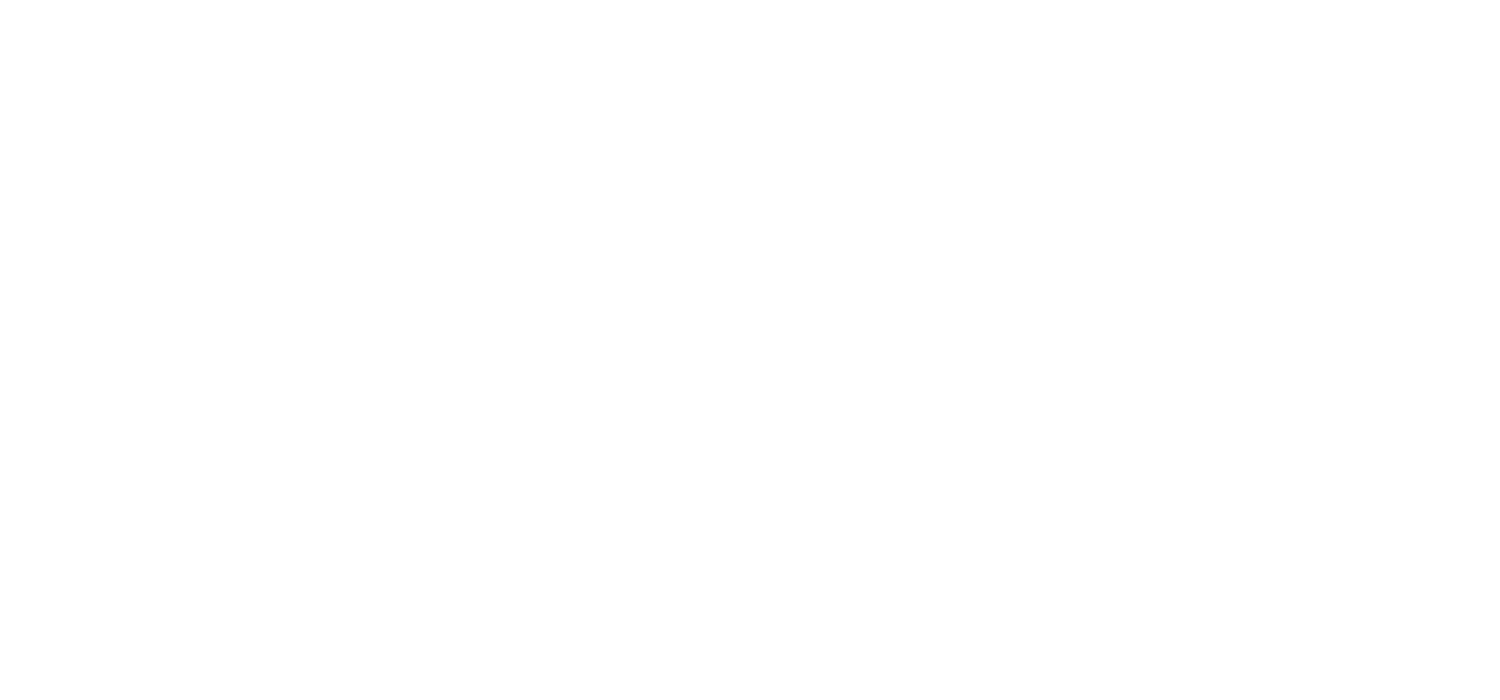

In [5]:
%matplotlib notebook
# Variable global
samplerate_des = 11025
model_name = 'definitive_segnet_based'
lowpass_params = {'freq_pass': 140, 'freq_stop': 150}
filter_parameters = {'bool': True , 'freq_pass': 980, 'freq_stop': 1000}

nmf_parameters = {'n_components': 15, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 200, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'energy_criterion'}

# Definición de la dirección de la base de datos de sonidos resp
db_resp = '_beta_cardiorespiratory_database/Resp_Sounds'
# Definición de la dirección de la base de datos de sonidos cardiacos
db_heart = '_beta_cardiorespiratory_database/Heart_Sounds'

# Archivos .wav de la carpeta
resp_filenames = [i for i in os.listdir(db_resp) if i.endswith('.wav')]
heart_filenames = [i for i in os.listdir(db_heart) if i.endswith('.wav')]

signal_index = 4
a = preprocess_study(signal_index, nmf_parameters, snr_expected=0, 
                     nmf_method='masked_segments', plot_segmentation=False,
                     filter_parameters=filter_parameters, plot_separation=True, 
                     base_factor=0, N_wind=100)

### Test eval_db

In [6]:
%matplotlib notebook
# Variable global
samplerate_des = 11025
model_name = 'definitive_segnet_based'
lowpass_params = {'freq_pass': 140, 'freq_stop': 150}
filter_parameters = {'bool': True , 'freq_pass': 980, 'freq_stop': 1000}
snr_expected = 0
nmf_parameters = {'n_components': 5, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 200, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'energy_criterion'}

# Definición de la dirección de la base de datos de sonidos resp
db_resp = '_beta_cardiorespiratory_database/Resp_Sounds'
# Definición de la dirección de la base de datos de sonidos cardiacos
db_heart = '_beta_cardiorespiratory_database/Heart_Sounds'

# Archivos .wav de la carpeta
resp_filenames = [i for i in os.listdir(db_resp) if i.endswith('.wav')]
heart_filenames = [i for i in os.listdir(db_heart) if i.endswith('.wav')]

nmf_method = 'on_segments'
eval_db(nmf_method, snr_expected, nmf_parameters, 
        filter_parameters=filter_parameters,
        file_mode='a', base_factor=0, N_wind=100)

Archivos:   0%|                                          | 0/12 [00:00<?, ?it/s]

Señal con índice 1
SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv

Señal con índice 2
SNR obtained = 9.64327466553287e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv

Señal con índice 3
SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv

Señal con índice 4
SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv

Señal con índice 5
SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 4ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv

Señal con índice 6
SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv

Señal con índice 7
SNR obtained = 9.64327466553287e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv

Señal con índice 8
SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv

Señal con índice 9
SNR obtained = -9.643274665532871e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv

Señal con índice 10
SNR obtained = 9.64327466553287e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv

Señal con índice 11
SNR obtained = 9.64327466553287e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv

Señal con índice 12
SNR obtained = -9.643274665532871e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step


C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Chris\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improv


Results on_segments
---------------------
Temporal correlation = 0.8363 $\pm$ 0.0639
Spectral correlation = 0.9778 $\pm$ 0.0308
MSE = 0.0062 $\pm$ 0.0038
SDR = 4.805 $\pm$ 2.5431


# Probar sobre una banda en específico

In [5]:
def nmf_process_v2(signal_in, samplerate, hs_pos, interval_list, nmf_parameters,
                filter_parameters, nmf_method='masked_segments'):
    '''Función que permite realizar la descomposición NMF en base a los 
    parámetros de interés a modificar.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal a descomponer.
    samplerate : int
        Tasa de muestreo de la señal.
    hs_pos : ndarray
        Señal binaria que indica las posiciones de los sonidos cardiacos.
    interval_list : list
        Lista con los intervalos donde se encuentran los sonidos cardiacos.
    nmf_parameters : dict
        Diccionario que contiene los parámetros de las funciones de 
        descomposición NMF.
    nmf_method : {'to_all', 'on_segments', 'masked_segments'}, optional
        Método de descomposición NMF a aplicar en la separación
        de fuentes. Por defecto es "masked_segments".
    
    Returns
    -------
    resp_signal : ndarray
        Señal respiratoria obtenida mediante la descomposición.
    heart_signal : ndarray
        Señal cardíaca obtenida mediante la descomposición.
    '''
    # Si es que se decide descomponer únicamente la franja de baja frecuencia 
    if filter_parameters['bool']:
        # Señal de entrada
        _, signal_to = \
                lowpass_filter(signal_in, samplerate,
                               freq_pass=filter_parameters['freq_pass'],
                               freq_stop=filter_parameters['freq_stop'],
                               normalize=False)
        
        # Señal a conectar con la respiración
        _, signal_upper = \
                highpass_filter(signal_in, samplerate, 
                                freq_stop=filter_parameters['freq_pass'], 
                                freq_pass=filter_parameters['freq_stop'],
                                normalize=False)
    
    else:
        signal_to = signal_in
    
    # Aplicando la separación de fuentes
    if nmf_method == 'to_all':
        (resp_signal, heart_signal), _ = \
            nmf_to_all(signal_to, samplerate, hs_pos=hs_pos, 
                       interval_list=interval_list, 
                       n_components=nmf_parameters['n_components'], 
                       N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'], 
                       noverlap=nmf_parameters['noverlap'], 
                       repeat=nmf_parameters['repeat'], 
                       padding=nmf_parameters['padding'], 
                       window=nmf_parameters['window'],
                       init=nmf_parameters['init'], 
                       solver=nmf_parameters['solver'], 
                       beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                       max_iter=nmf_parameters['max_iter'],
                       alpha_nmf=nmf_parameters['alpha_nmf'], 
                       l1_ratio=nmf_parameters['l1_ratio'], 
                       random_state=nmf_parameters['random_state'],
                       dec_criteria=nmf_parameters['dec_criteria'])
    
    
    elif nmf_method == 'on_segments':
        resp_signal, heart_signal = \
            nmf_on_segments(signal_to, samplerate, interval_list=interval_list, 
                            n_components=nmf_parameters['n_components'],
                            N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'],  
                            N_fade=nmf_parameters['N_fade'], 
                            noverlap=nmf_parameters['noverlap'], 
                            repeat=nmf_parameters['repeat'], 
                            padding=nmf_parameters['padding'], 
                            window=nmf_parameters['window'],
                            init=nmf_parameters['init'], 
                            solver=nmf_parameters['solver'], 
                            beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                            max_iter=nmf_parameters['max_iter'],
                            alpha_nmf=nmf_parameters['alpha_nmf'], 
                            l1_ratio=nmf_parameters['l1_ratio'], 
                            random_state=nmf_parameters['random_state'],
                            dec_criteria=nmf_parameters['dec_criteria'])
    
    
    elif nmf_method == 'masked_segments':
        (resp_signal, heart_signal), _ = \
            nmf_masked_segments(signal_to, samplerate, hs_pos=hs_pos, 
                                interval_list=interval_list, 
                                n_components=nmf_parameters['n_components'],
                                N=nmf_parameters['N'], N_lax=nmf_parameters['N_lax'],  
                                N_fade=nmf_parameters['N_fade'], 
                                noverlap=nmf_parameters['noverlap'], 
                                repeat=nmf_parameters['repeat'], 
                                padding=nmf_parameters['padding'], 
                                window=nmf_parameters['window'],
                                init=nmf_parameters['init'], 
                                solver=nmf_parameters['solver'], 
                                beta=nmf_parameters['beta'], tol=nmf_parameters['tol'], 
                                max_iter=nmf_parameters['max_iter'],
                                alpha_nmf=nmf_parameters['alpha_nmf'], 
                                l1_ratio=nmf_parameters['l1_ratio'], 
                                random_state=nmf_parameters['random_state'],
                                dec_criteria=nmf_parameters['dec_criteria'])
    
    
    # Si es que se filtró, se vuelve a conectar con la información de alta
    # frecuencia. 
    if filter_parameters['bool']: 
        # Filtrando frecuencias altas
        _, resp_signal = \
                lowpass_filter(resp_signal, samplerate,
                               freq_pass=filter_parameters['freq_pass'],
                               freq_stop=filter_parameters['freq_stop'], 
                               normalize=False)
        _, heart_signal = \
                lowpass_filter(heart_signal, samplerate,
                               freq_pass=filter_parameters['freq_pass'],
                               freq_stop=filter_parameters['freq_stop'], 
                               normalize=False)
        
        # Conectar la señal respiratoria con la banda superior de la señal
        resp_signal = resp_signal + signal_upper[:len(resp_signal)]
    
    return resp_signal, heart_signal


def get_intervals_adjusted(signal_index, nmf_parameters, snr_expected, filter_parameters,
                           base_factor= 0.05, N_wind=100, N_expand=100):
    def _adjust_length(signal_in, interval_list, N_exp):
        # Definición del heart_out de salida
        y_out = np.zeros(len(signal_in))
        
        # Definición de la lista modificada
        interval_list_new = list()
        
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0] - N_exp
            upper = interval[1] + N_exp
            
            # Condiciones de borde
            if lower <= 0:
                lower = 0
            if upper > len(signal_in):
                upper = len(signal_in) - 1
            
            # Definiendo los límites
            y_out[lower:upper] = 1
            interval_list_new.append([lower, upper])
        
        return y_out, interval_list_new
    
    
    ######### Import de archivos de audio #########
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Clasificando
    _, y_hat_to, (y_out2, _, _) = \
        signal_segmentation(heart_to, samplerate_des, model_name,
                            length_desired=len(mixed_to), 
                            lowpass_params=lowpass_params, 
                            plot_outputs=False)
    
    # Definiendo la lista de intervalos
    interval_list = find_segments_limits(y_out2, segments_return='Heart')
    
    # Modificando
    y_out2_new, interval_list_new = _adjust_length(y_out2, interval_list, N_exp=N_expand)
    
    print(interval_list_new)
    
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign_on = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign_on = conv_sign_on / max(abs(conv_sign_on)) * (1 - base_factor) + base_factor
    heart_on = heart_to * conv_sign_on
    
    # Señal para apagar sonidos cardiacos
    conv_sign_off = np.convolve((1 - y_out2_new), np.hamming(N_wind), 'same')
    conv_sign_off = conv_sign_off / max(abs(conv_sign_off)) * (1 - base_factor) + base_factor
    heart_off = heart_to * conv_sign_off
    
    plt.figure(figsize=(9,5))
    plt.plot(heart_to)
    plt.plot(y_out2_new)
    plt.plot()
    
    return heart_to, heart_on, heart_off
    

def apply_interval_list(signal_in, interval_list, N_wind=100):
    def _interval_to_signal(_signal_in, interval_list):
        # Definición del heart_out de salida
        y_out = np.zeros(len(_signal_in))
                
        # Intervalo
        for interval in interval_list:
            # Definición de los límites
            lower = interval[0]
            upper = interval[1]
            
            # Definiendo los límites
            y_out[lower:upper] = 1
        
        return y_out
    
    y_to = _interval_to_signal(signal_in, interval_list)
    
    # Señal para apagar sonidos cardiacos
    conv_sign_off = np.convolve((1 - y_to), np.hamming(N_wind), 'same')
    conv_sign_off = conv_sign_off / max(abs(conv_sign_off))
    heart_off = heart_to * conv_sign_off
    
    plt.figure(figsize=(9,5))
    plt.plot(signal_in)
    plt.plot(y_to)
    plt.plot()
    
    return heart_off
    

SNR obtained = -9.643274665532871e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step
[[1363, 2965], [4805, 5906], [8474, 10023], [12095, 13194], [15941, 17471], [19432, 20531], [23220, 24757], [26768, 27866], [30553, 32091], [34113, 35210], [37896, 39433], [41451, 42549], [45239, 46776], [48786, 49884], [52575, 54112], [56123, 57221], [59905, 61443], [63465, 64563], [67215, 68755], [70806, 71905], [74613, 76149], [78167, 79260], [81949, 83477], [85581, 86664]]


<IPython.core.display.Javascript object>


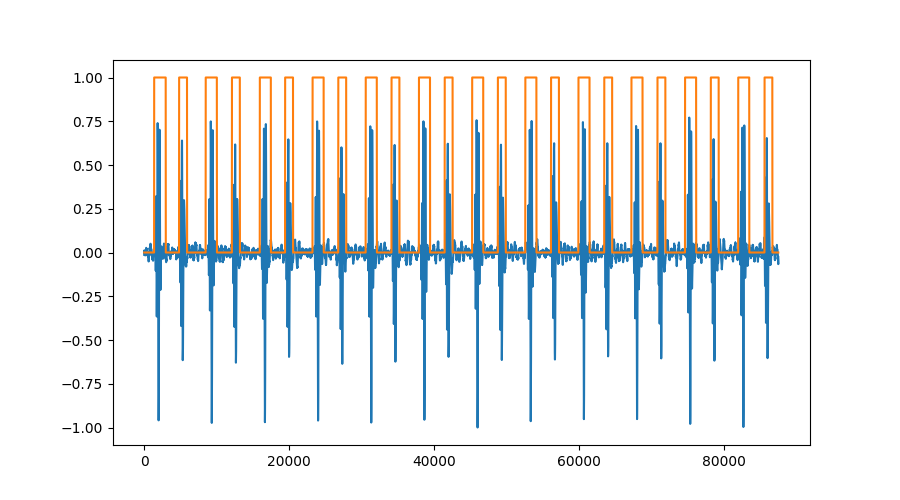

<IPython.core.display.Javascript object>


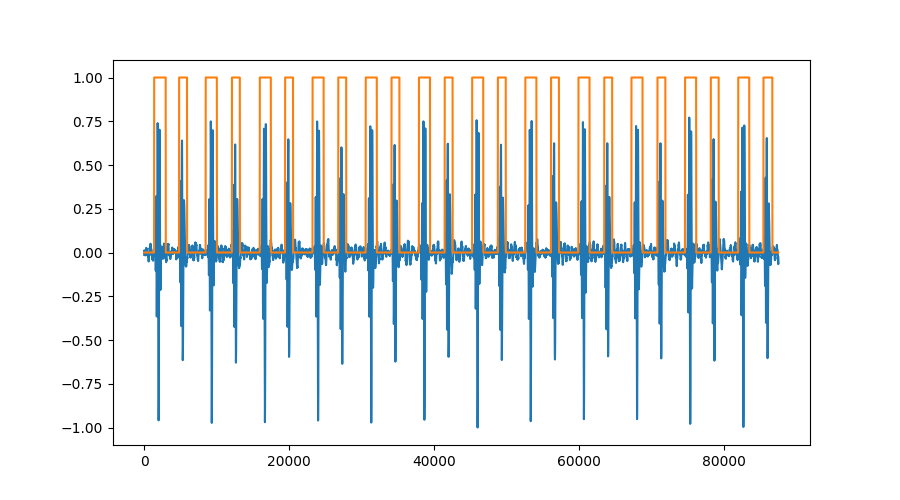

In [7]:
%matplotlib notebook
# Variable global
samplerate_des = 11025
model_name = 'definitive_segnet_based'
lowpass_params = {'freq_pass': 140, 'freq_stop': 150}
filter_parameters = {'bool': True , 'freq_pass': 980, 'freq_stop': 1000}

nmf_parameters = {'n_components': 15, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 200, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'energy_criterion'}

# Definición de la dirección de la base de datos de sonidos resp
db_resp = '_beta_cardiorespiratory_database/Resp_Sounds'
# Definición de la dirección de la base de datos de sonidos cardiacos
db_heart = '_beta_cardiorespiratory_database/Heart_Sounds'

# Archivos .wav de la carpeta
resp_filenames = [i for i in os.listdir(db_resp) if i.endswith('.wav')]
heart_filenames = [i for i in os.listdir(db_heart) if i.endswith('.wav')]

signal_index = 12
heart_to, heart_on, heart_off = \
            get_intervals_adjusted(signal_index, nmf_parameters, snr_expected=0, 
                                   filter_parameters=filter_parameters,
                                   base_factor=0, N_wind=100, N_expand=0)

# interval_list = [[1363, 2965], [4805, 5906], [8474, 10023], [12095, 13194],
#                  [15941, 17471], [19432, 20531], [23220, 24757], [26768, 27866], 
#                  [30553, 32091], [34113, 35210], [37896, 39433], [41451, 42549], 
#                  [45239, 46776], [48786, 49884], [52575, 54112], [56123, 57221], 
#                  [59905, 61443], [63465, 64563], [67215, 68755], [70806, 71905], 
#                  [74613, 76149], [78167, 79260], [81949, 83477], [85432, 86664]]

# heart_off = apply_interval_list(heart_to, interval_list)

In [22]:
Audio(heart_off, rate=samplerate_des)

In [23]:
print(interval_list)

[[1363, 2965], [4805, 5906], [8474, 10023], [12095, 13194], [15941, 17471], [19432, 20531], [23220, 24757], [26768, 27866], [30553, 32091], [34113, 35210], [37896, 39433], [41451, 42549], [45239, 46776], [48786, 49884], [52575, 54112], [56123, 57221], [59905, 61443], [63465, 64563], [67215, 68755], [70806, 71905], [74613, 76149], [78167, 79260], [81949, 83477], [85432, 86664]]


### Testeo de sonido

SNR obtained = 0.0 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 3ms/step
[[2381, 3592], [4754, 5276], [8952, 10518], [11493, 12600], [15612, 17139], [18561, 19662], [23449, 24983], [26442, 27540], [31560, 33093], [34512, 35609], [39472, 41005], [42439, 43536], [47112, 48641], [50133, 51232], [54882, 56418], [57953, 59050], [63030, 64559], [66051, 67148], [71437, 72971], [74421, 75518], [79346, 80880], [82360, 83457], [86948, 88488], [90078, 91173], [94854, 96389], [97751, 98855], [102427, 103961], [105453, 106555], [109847, 111376], [112857, 113966], [116677, 118208], [119530, 120638], [123559, 125099], [126456, 127559], [130642, 132194], [133659, 134748], [137683, 139222], [140632, 141734], [144722, 146263], [147817, 148892], [151668, 153214]]


<IPython.core.display.Javascript object>


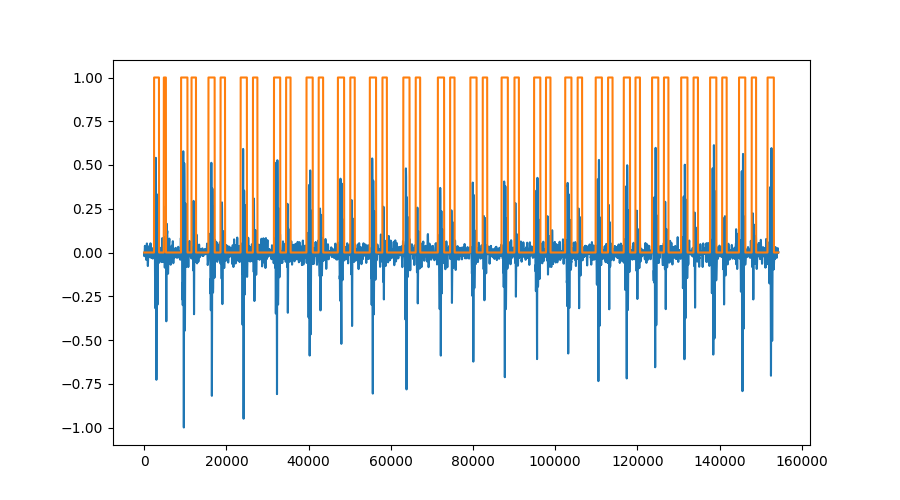

<IPython.core.display.Javascript object>


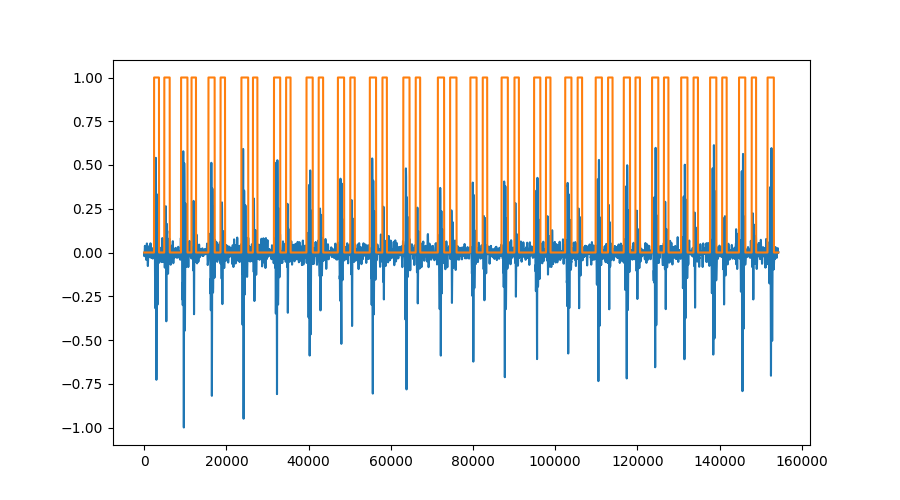

In [9]:
signal_index = 1
heart_to, heart_on, heart_off = \
            get_intervals_adjusted(signal_index, nmf_parameters, snr_expected=0, 
                                   filter_parameters=filter_parameters,
                                   base_factor=0, N_wind=100, N_expand=0)

with open(f'{db_heart}/Interval_list_corrected.txt', 'r', encoding='utf8') as file:
    # Lectura del diccionario
    dict_to_rev = literal_eval(file.readline().strip())

heart_off = apply_interval_list(heart_to, dict_to_rev[signal_index])

In [52]:
Audio(heart_off, rate=samplerate_des)

In [53]:
Audio(heart_to, rate=samplerate_des)

# Obtener espectrogramas

In [3]:
def get_spectrogram(signal_in, samplerate, N=512, padding=0, repeat=0, noverlap=0, 
                    window='tukey', whole=False):
    '''Función que permite obtener la STFT de una señal.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada a transformar.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es 512.
    padding : int, optional
        Cantidad de puntos de zero padding al final de la señal. Por defecto es 0.
    repeat : int, optional
        Cantidad de veces que se repite la señal en el cálculo de la STFT. Por defecto es 0.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la STFT. Por defecto
        es 0.
    window : {'tukey', 'hamming', 'hann', 'nuttall'}, None, optional
        Ventana a utilizar para el cálculo de la STFT. Por defecto es 'tukey'. Con None se
        aplica ventana rectangular.
    whole : bool, optional
        Indica si se calcula la STFT hasta samplerate (True) o hasta samplerate // 2 (False).
        Por defecto es False.
        
    Returns
    -------
    t : ndarray
        Arreglo que indica las etiquetas temporales de la matriz que representa la STFT.
    f : ndarray
        Arreglo que indica las etiquetas frecuenciales de la matriz que representa la STFT.
    S : ndarray
        Espectrograma calculado a partir de la STFT de la señal de entrada.
    '''
    
    # Corroboración de criterios: noverlap <= N - 1
    if N <= noverlap:
        raise Exception('noverlap debe ser menor que N.')
    elif noverlap < 0:
        raise Exception('noverlap no puede ser negativo')
    else:
        noverlap = int(noverlap)
        
    # Propiedad de repeat
    repeat = int(repeat) if repeat >= 0 else 0
    
    # Lista donde se almacenará los valores del espectrograma
    to_fft = []
    # Lista de tiempo
    times = []
    
    # Variables auxiliares
    t = 0   # Tiempo
    
    # Definición del paso de avance
    step = N - noverlap
    
    # Si el norverlap es 0, se hacen ventanas 2 muestras más grandes 
    # para no considerar los bordes izquierdo y derecho (que son 0)
    if noverlap == 0:
        N_window = N + 2
    else:
        N_window = N
    
    # Seleccionar ventana.
    if window == 'tukey':
        wind_mask = tukey(N_window)
    elif window == 'hamming':
        wind_mask = hamming_window(N_window)
    elif window == 'hann':
        wind_mask = hann_window(N_window)
    elif window == 'nuttall':
        wind_mask = nuttall(N_window)
    elif window is None:
        wind_mask = np.array([1] * N_window)
    
    # Y se recorta en caso de noverlap cero
    wind_mask = wind_mask[1:-1] if noverlap == 0 else wind_mask
    
    # Definición de bordes de signal_in
    signal_in = np.concatenate((np.zeros(N//2), signal_in, np.zeros(N//2)))
    
    # Iteración sobre el audio
    while signal_in.size != 0:
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(signal_in) >= N:
            # Se obtienen las N muestras de interés
            signal_frame = signal_in[:N]
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[step:]
            
        # En la última iteración se añaden ceros para lograr el largo N
        else:
            # Definición del último frame
            last_frame = signal_in[:]
            
            # Se rellena con ceros hasta lograr el largo            
            signal_frame = np.append(last_frame, [0] * (N - len(last_frame)))
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[:0]
    
        # Agregando a los vectores del espectro
        to_fft.append(signal_frame)
        
        # Agregando al vector de tiempo
        times.append(t)
        t += step/samplerate
    
    # Ventaneando
    signal_wind = np.array(to_fft) * wind_mask

    # Repetición de la señal
    if repeat > 0:
        signal_wind = np.pad(signal_wind, pad_width=((0,0), (repeat * N // 2, repeat * N // 2)),
                             mode='reflect')
    
    # Aplicando padding
    zeros = np.zeros((signal_wind.shape[0], padding), dtype=signal_wind.dtype)
    signal_padded = np.concatenate((signal_wind, zeros), axis=1)

    # Aplicando transformada de fourier
    spect = np.fft.fft(signal_padded)
    
    # Preguntar si se quiere el espectro completo, o solo la mitad (debido a
    # que está reflejado hermitianamente)
    if whole:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate, N + padding + repeat * 2 * (N // 2))

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex128)
    else:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate//2, ( N + padding + repeat * 2 * (N // 2))//2 + 1)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, 
                         dtype=np.complex128)[:, :(N + padding + repeat * 2 * (N // 2))//2 + 1]

    # Escalando
    spect *= np.sqrt(1 / (N * np.sum(wind_mask ** 2)))
    
    # Se retornan los valores que permiten construir el espectrograma 
    # correspondiente
    return times, freqs, spect.T

In [7]:
# Definición de la dirección de la base de datos
db_heart = '_beta_cardiorespiratory_database/Heart_Resp_Sounds'

# Archivos .wav de la carpeta
heart_filenames = [i for i in os.listdir(db_heart) if i.endswith('.wav')]

# Ejemplo
audio, samplerate = sf.read(f'{db_heart}/{heart_filenames[3]}')

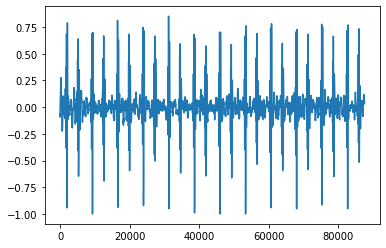

In [8]:
plt.plot(audio)